# KKBox Churn Prediction Challenge 
Carmen Easterwood & Hawina Bulcha

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import FunctionTransformer, StandardScaler, Imputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Business Understanding


KKBox is a music streaming service based in Taiwan, which offers customers access to songs based on a payment plan. Customer retention is key to business stability, particularly when that business is based off of subscriptions. Yet prior to implementing any strategies to improve retention, the business needs an accurate method to discern those subscribers most likely to churn. KKBox defines a customer as having "churned" if no new transactions are initiated within a month of the user's subscription expiring.  

**Problem Statement**: Provide a method to identify customers most likely to churn. 

We approach this as a supervised learning problem where the requirement is to build a classifier which maps the available attributes of a customer to a label for whether the customer has churned or not. The relevant metrics include any attributes which are directly or indirectly related to a customer's behavior. 

# Data Understanding and Restrictions

All of the features used in our classifiers are taken directly or otherwise derived from the four files provided by KKBox on members, user logs, transactions and train data. Members consists of personal information about each subscriber, presented as a single row per subscriber with a unique identifier. Similarly, the train file provides an indicator for whether each subscriber churned during February 2017. Transactions and user logs cover payment and streaming information respectively during the time period January 2015 - February 2017. The unit of granularity for transactions is a payment or cancellation, whereas a single row in user_logs corresponds to an instance where the user logged in and streamed music.  

The initial data consists of 6 million member profiles, 21 million transaction records, and 392 million user logs. After the competition started, KKBox posted transaction and user log data for March 2017 in order to predict April 2017 churn.

Since Jupyter notebooks cannot handle this amount of data, we restrict the dataset to a random sample of 20,000 users and all their related information in each of the files. We then randomly split this into a train/test set for analysis. In doing so, we have also adjusted the requirement to predicting churn information within the same time period. The original requirement was training the model on one time period with feature data through February 2017, and churn labels in March 2017. The prediction would be based on a different time period with features through March 2017, and churn labels to be predicted in April 2017. As a result of the different time periods, the KKBox data allows for the same user to exist in both the train and test sets. 

However, our analysis will stick to the original time period (February 2017) for both consuming training data and predicting test data for a random sample of 20,000 users. In this way, we ensure that the users in the train set are different from those of the test set. We first generate a list of these users from the train file and use it to filter the other files.

## Create Filtered Data Files

### Get Set of 20,000 Member IDs and Churn Labels

In [2]:
# Load a sample of 10,000 records from the KKBox training data
np.random.seed(0)
churn_labels = pd.read_csv('data/train.csv').sample(n=20000)
print ('''RECORDS: {:,}
Percent Churned: {:.1f}%'''.format(len(churn_labels),
                100.0 * churn_labels.is_churn.mean()))

RECORDS: 20,000
Percent Churned: 6.5%


In [3]:
churn_labels[:5]

,msno,is_churn
626358,yQ1Vuk7eY1xYfH3RfpWH9kNHge/3svoZUJrIE3X8n0g=,0
942191,UDkNk3peTC4h1GjPc4L6jfrE5g7zIok/8xo4l+jOl34=,0
341874,jd65Fxpsab+p6Y6bkWr55Nu0rIW0HeC4TcxhzRPf61M=,0
407370,o0BPQDi2rOsYpSkftnaoMnT2kTRv8o3if/kQWFexKN0=,0
704627,IT+xyhv8kTqdb0fHamFScH/7bgmcd7M7+DTeA1iALz4=,0


### Create Files with Data for Sample of 20,000 Users
Next we create our own data files that contain the member profiles, transactions, and user logs of just our 20,000 members. We put the 20,000 member IDs into a set (along with `msno` so that we catch the header row of each file), and then we scan the original data files, looking for records that pertain to one of our member IDs. When we find relevant records, we write them to a separate CSV file. These filtered CSV files are significantly smaller and can be read into Python's memory.

In [4]:
# Create set and add 'msno' so we catch the header row
churn_labels2 = list(churn_labels.msno)
churn_labels2.insert(0, 'msno')
subset_ids = set(churn_labels2)

In [5]:
# Get filtered member data into CSV
with open('data/members_v3.csv') as f:
    with open('members_filtered.csv', 'w') as g:
        for line in f:
            this_id = line.split(',')[0]
            if this_id in subset_ids:
                g.write(line)

In [6]:
# Get filtered transaction data into CSV
with open('data/transactions.csv') as f:
    with open('transactions_filtered.csv', 'w') as g:
        for line in f:
            this_id = line.split(',')[0]
            if this_id in subset_ids:
                g.write(line)

In [7]:
# Get filtered user log data into CSV
with open('data/user_logs.csv') as f:
    with open('user_logs_filtered.csv', 'w') as g:
        for line in f:
            this_id = line.split(',')[0]
            if this_id in subset_ids:
                g.write(line)

In [8]:
# Load filtered member data
members = pd.read_csv('members_filtered.csv')
print ('''MEMBERS RECORDS: {:,}'''.format(len(members)))

# Load filtered transaction data
trans_detail = pd.read_csv('transactions_filtered.csv')
print ('''TRANSACTION RECORDS: {:,}'''.format(len(trans_detail)))

# Load filtered user_log data and throw out a couple of bad records
logs_detail = pd.read_csv('user_logs_filtered.csv')
print ('''USER LOGS RECORDS: {:,}'''.format(len(logs_detail)))
logs_detail = logs_detail[(logs_detail.total_secs > 0) & (logs_detail.total_secs <= 86400)]
print ('''FILTERING OUT LOGS WITH BAD total_secs VALUES: {:,}'''.format(len(logs_detail)))


MEMBERS RECORDS: 17,673
TRANSACTION RECORDS: 318,261
USER LOGS RECORDS: 4,925,235
FILTERING OUT LOGS WITH BAD total_secs VALUES: 4,922,563


There is a very small number of user logs (<0.1%) that we throw out because the data is unreasonable. The logs contain a variable `total_secs` which is the total number of seconds of songs that the user listened to on the day of the login. We remove the following two cases:
+ `total_secs` $\leq$ 0
+ `total_secs` > 86,400 (the total number of a seconds in a day)

The final data files consist of 17,673 member profiles, 318,261 transactions and 4,922,563 user_logs rows, which we aggregate and merge into the final dataset.

## Data Profiling, Feature Extraction and Aggregation

### Members
We take a look at the filtered member data. As noted above, there are fewer than 20,000 records in this dataset. This is because some users do not have member profiles.

In [9]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,eIOUZ5I+NV/3EDfn/U/tMepn4FJt2SdzOrWGH1tNlYI=,5,24,male,3,20141025
1,+BJTJRs9+WEUO69OZ7HbkFMOYJ+FV45tA6foNlUrGqE=,1,0,NaN,4,20170120
2,YDnDgwmKMDQMmJL2U3aaxmwZ1i2NcABOdD1CXibBmh0=,14,47,female,9,20060427
3,3MgE7wEbKzAETdMljABlpYTUSoIJ3svHSK0nkIViKUM=,14,40,male,9,20061023
4,dI97ob9fpC75DPCBqtWCG7qfqKNNi/9F1PczUf/iNGA=,5,35,female,9,20070413



 The absence of member data can point to some underlying attribute of the customer. For example: Those members whose personal information is not available might be at their own request to have their personal information deleted from the KKBox system or they did not complete their profile to begin with. We later account for this with a vectorized feature with indicators for whether the member data is missing (`NaN`), incomplete or complete.

The members file contains personal information such as member age, gender, city and registration method and date. We fix the member age variable and add some features:
+ According to KKBox, member age (`bd`) has "outlier values" ranging from -7000 to 2015. We null out any values $\leq$0 or >100, since those values can't be real ages.
+ We add a column for `registration_month` (based on the registration date). We believe this could be important if, for example, memberships purchased for Christmas are less likely to be maintained than memberships purchased at other times of the year.
+ `member_profile_complete` is an indicator for whether the member's profile has been completely filled out. If the member has any `NaN` values, it is considered incomplete. A weakness of this feature is that we don't know if there are nulls in the `city` or `registered_via` columns. (For example, it is possible that `city` = 1 means the city is unknown.)

In [10]:
# Transformations to member data

# Replace impossible age values with NaN
members['bd'] = members['bd'].apply(lambda x: np.NaN if (x <= 0 or x > 100) else x)

# Add variable for registration month
members['registration_month'] = pd.to_datetime(members['registration_init_time'], format='%Y%m%d').dt.month

# Add variable for whether member profile is complete
members['member_profile_complete'] = [not members.loc[x,:].isnull().any() for x in range(len(members))]

In [11]:
# See final member data
print (members.shape)
members.head()

(17673, 8)


,msno,city,bd,gender,registered_via,registration_init_time,registration_month,member_profile_complete
0,eIOUZ5I+NV/3EDfn/U/tMepn4FJt2SdzOrWGH1tNlYI=,5,24.0,male,3,20141025,10,True
1,+BJTJRs9+WEUO69OZ7HbkFMOYJ+FV45tA6foNlUrGqE=,1,NaN,NaN,4,20170120,1,False
2,YDnDgwmKMDQMmJL2U3aaxmwZ1i2NcABOdD1CXibBmh0=,14,47.0,female,9,20060427,4,True
3,3MgE7wEbKzAETdMljABlpYTUSoIJ3svHSK0nkIViKUM=,14,40.0,male,9,20061023,10,True
4,dI97ob9fpC75DPCBqtWCG7qfqKNNi/9F1PczUf/iNGA=,5,35.0,female,9,20070413,4,True


**Now let's review the distribution of the member variables:**

+ There are 21 possible cities, and city #1 is the most popular by far.
+ There are 5 registration methods, which might correspond to things like mobile, desktop, or certain internet browsers, but we aren't given this information.

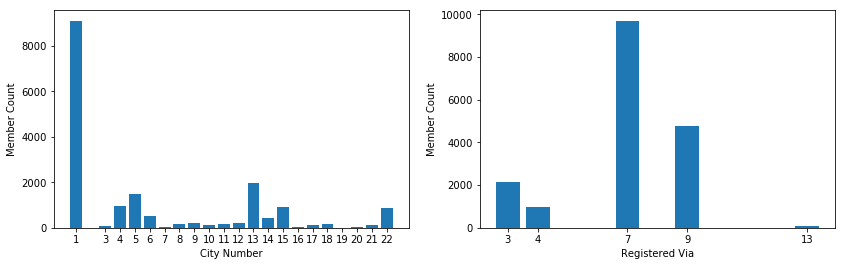

In [12]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
c = members.groupby(['city'], as_index=False)['msno'].count()
plt.bar(c.city, c.msno)
plt.xlabel('City Number')
plt.xticks(np.array(c.city))
plt.ylabel('Member Count')

plt.subplot(1, 2, 2)
rv = members.groupby(['registered_via'], as_index=False)['msno'].count()
plt.bar(rv.registered_via, rv.msno)
plt.xlabel('Registered Via')
plt.xticks(np.array(rv.registered_via))
plt.ylabel('Member Count')

+ KKBox was founded in 2004, so the first registrations occur then. Annual registrations are flat for a few years, until they start rising quickly in 2010. We only have 2 months of data for 2017, so there are not many 2017 registrations in this dataset.
+ There is a distinct V shape in the distribution of registration month, but it is not immediately clear why registrations are lower in April and higher at the end of the year.

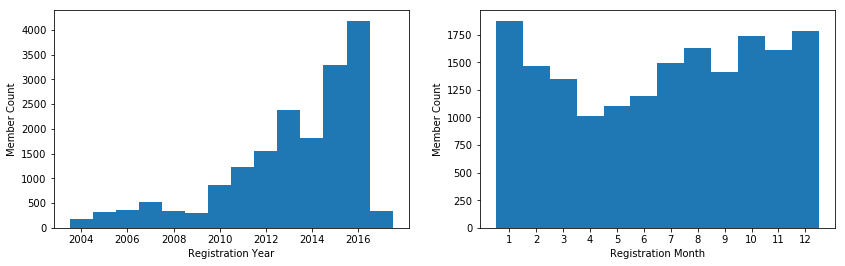

In [13]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
ry = pd.to_datetime(members.registration_init_time, format='%Y%m%d').dt.year
plt.hist(ry, bins=np.arange(float(np.min(ry))-0.5, float(np.max(ry))+1.5))
plt.xlabel('Registration Year')
plt.xticks(np.arange(min(ry), max(ry)+1, 2))
plt.ylabel('Member Count')

plt.subplot(1, 2, 2)
plt.hist(members.registration_month, bins=np.arange(0.5, 13.5))
plt.xlabel('Registration Month')
plt.xticks(np.arange(1, 13))
plt.ylabel('Member Count')

+ Members are fairly young, with a median age of 28 and mean of 30.
+ The majority of members do not provide gender information. Among those that do, there is a pretty even split between males and females.
+ Less than half of members have fully completed their profiles. (Keeping in mind that the true number could be even lower than 43%, because there are two columns whose values we don't know the meaning of.)

In [14]:
print ('''{}

{}

{}'''.format(members.bd.describe().round(1),
             members.gender.value_counts(normalize=True, dropna=False).round(4),
             members.member_profile_complete.value_counts(normalize=True).round(4)))

count    7943.0
mean       30.0
std         9.0
min         4.0
25%        24.0
50%        28.0
75%        34.0
max        96.0
Name: bd, dtype: float64

NaN       0.5504
male      0.2349
female    0.2147
Name: gender, dtype: float64

False    0.5615
True     0.4385
Name: member_profile_complete, dtype: float64


### Transactions
Reading in the filtered transactions file, we can see that all members have transaction information. There are approximately 16 transactions per member.

In [15]:
unq_msno = trans_detail.msno.nunique()
print ('''Unique Number of Members in Transactions File: {:,}'''.format(unq_msno))
print ('''Average Transactions per Member: {:.1f}'''.format(len(trans_detail) / unq_msno))
trans_detail.head()

Unique Number of Members in Transactions File: 20,000
Average Transactions per Member: 15.9


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,rSdCksIr/MGJ5DXs7R5OyXU13W8u80sijZiFqg6NnLY=,39,31,149,149,1,20150131,20150303,0
1,kAa1U+BoLXO23mjzMKXSObDhCeet663N8uDOE/QujLM=,39,31,149,149,1,20150131,20150326,0
2,D+W1Mk6FI8cY6uXvNPwwslnL1WPaiYuoiM3bX/YqjLk=,31,30,149,149,1,20160331,20160430,0
3,CpF4AnwzjYroFT6tifgmFF3eIo84fnTJp3OIZnvDvCw=,41,30,149,149,1,20160430,20160601,0
4,mBNBB4YhEc6TQaDJX9XmwpPyMgPXt++cJ5ry8CCpeS8=,39,30,149,149,1,20151202,20160119,0


The transactions file contains information on each payment activity, including the date it was initiated, the amount paid and the payment plan of the customer, as well as an indicator for whether the payment was on auto-renew.

We now add a few columns to the transaction dataset before aggregating it into a single record per user. First, we pull in the registration date for each member, when it is available. This will be used to calculate customer lifetime. Approximately 90% of transactions can be associated with a member registration date.

In [16]:
# Transformations to transaction data

# 1. Pull in registration date for each member

def get_reg_date(df):
    df = pd.merge(df, members[['msno','registration_init_time']], on='msno', how='left')
    print('''TRANSACTIONS FROM MEMBERS WITH A MEMBER PROFILE: {:.1f}%'''.format(100.0 * df['registration_init_time'].count() / len(df)))
    return df

trans_detail = get_reg_date(trans_detail)

TRANSACTIONS FROM MEMBERS WITH A MEMBER PROFILE: 89.9%


Next we will recalculate some expiration dates that are incorrect. These calculations are based on the idea that `transaction_date` + `payment_plan_days` should be relatively close to `membership_expire_date`. We believe the transaction dates are correct because they fall within the expected range (Jan 2015 - Feb 2017), but the expiration dates are sometimes incorrect because their range includes some impossible values (e.g. 1/1/1970).
+ An expiration date can be **too big** if the difference between expiration date and transaction date is more than a month *larger* than the payment plan days. (E.g. a transaction on 5/1/16 for a 30 day plan, but the expiration date is on 12/1/16.)
+ An expiration date can be **too small** if the difference between expiration date and transaction date is more than a week *smaller* than the payment plan days. (E.g. a transaction on 5/1/16 for a 30 day plan, but the expiration date is on 5/10/16.)

When we find an expiration date out of range, we recalculate it, and the calculation depends on whether the transaction is a cancellation transaction.
+ If `is_cancel` = 0: new expire date = `transaction_date` + `payment_plan_days` + 1 
+ If `is_cancel` = 1: new expire date = `transaction_date`

In [17]:
# Transformations to transaction data

# 2. Find expiration dates that are out of range and re-calculate them

def new_expire_date(row):
    if row['expire_too_small'] or row['expire_too_big']:
        if row['is_cancel'] == 1:
            return row['transaction_date']
        else:
            new_dttm = pd.to_datetime(row['transaction_date'], format='%Y%m%d') + dt.timedelta(days=row['payment_plan_days']+1)
            return (new_dttm.year * 10000) + (new_dttm.month * 100) + new_dttm.day
    else:
        return row['membership_expire_date']

def get_new_expire_date(df):
    # Get datetime version of dates for calculations
    trans_dttm = pd.to_datetime(df['transaction_date'], format='%Y%m%d')
    expire_dttm = pd.to_datetime(df['membership_expire_date'], format='%Y%m%d')
    diff = expire_dttm.sub(trans_dttm).dt.days

    # TOO SMALL: (expire date - transaction date) < (plan days - 1 week)
    df['expire_too_small'] = diff < (df['payment_plan_days'] - 7)

    # TOO BIG: (expire date - transaction date) > (plan days + 1 day + 1 month)
    df['expire_too_big'] = diff > (df['payment_plan_days'] + 32)

    print( '''EXPIRATION DATES OUT OF RANGE:
    Expire date too small: {:.1f}%
    Expire date too big: {:.1f}%
    '''.format(100.0 * df['expire_too_small'].mean(), 100.0 * df['expire_too_big'].mean()))

    # Calculate what the expiration date *should* be
    df['new_expire_date'] = df.apply(lambda x: new_expire_date(x), axis=1)

get_new_expire_date(trans_detail)

EXPIRATION DATES OUT OF RANGE:
    Expire date too small: 1.6%
    Expire date too big: 2.4%
    


Finally we add a Boolean variable for whether the transaction payment was late. We define a payment as late if the transaction occurs _after_ the expiration date of the previous transaction. So for example, if my membership expires on March 31 and I don't get around to making my next payment until April 10, my payment is late and I had a gap in coverage of 10 days. Users who do this (as opposed to auto-renewing each month) may be at a higher risk for churning. By definition, a user's first transaction can never be considered late since there are no previous transactions.

In [18]:
# Transformations to transaction data

# 3. Boolean for whether payment is late ----> 18.7% of transactions

def get_is_late(df):
    # Sort transactions by most recent first and reset index
    df.sort_values(by=['msno','transaction_date','new_expire_date'], ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Add rank variable for transactions (most recent transaction first)
    df['rank'] = df.groupby(['msno']).transaction_date.rank(ascending=False)

    # Create list of transactions and reduce their rank by 1 (rank of the previous transaction)
    prev_trans = df[['rank','msno','transaction_date','new_expire_date']]
    prev_trans.columns = ['rank','msno','prev_trans_date','prev_expire_date']
    prev_trans['rank'] = prev_trans['rank'].apply(lambda x: x - 1)

    # Gets transaction & expire date from previous transaction in line with each record
    df = df.merge(prev_trans, how='left', on=['msno','rank'])

    # Late if: current transaction date > previous expire date
    df['is_late'] = df['transaction_date'] > df['prev_expire_date']
    df.drop(['rank','prev_trans_date','prev_expire_date'], axis=1, inplace=True)
    
    print ('''LATE PAYMENTS: {:.1f}%'''.format(100.0 * df['is_late'].mean()))
    return df

trans_detail = get_is_late(trans_detail)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


LATE PAYMENTS: 18.0%


We now have all the columns we need in the transaction dataset, so let's take a look at them and their distributions.

In [19]:
# See final transaction detail
print (trans_detail.shape)
trans_detail.head()

(318261, 14)


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,registration_init_time,expire_too_small,expire_too_big,new_expire_date,is_late
0,zztRj67GpP0kdrpfKJ4X4bUrF+ljVCkR0K8cRDIbzRI=,41,30,99,99,1,20170225,20170325,0,20160825.0,False,False,20170325,False
1,zztRj67GpP0kdrpfKJ4X4bUrF+ljVCkR0K8cRDIbzRI=,41,30,99,99,1,20170125,20170225,0,20160825.0,False,False,20170225,False
2,zztRj67GpP0kdrpfKJ4X4bUrF+ljVCkR0K8cRDIbzRI=,41,30,99,99,1,20161225,20170125,0,20160825.0,False,False,20170125,False
3,zztRj67GpP0kdrpfKJ4X4bUrF+ljVCkR0K8cRDIbzRI=,41,30,99,99,1,20161125,20161225,0,20160825.0,False,False,20161225,False
4,zztRj67GpP0kdrpfKJ4X4bUrF+ljVCkR0K8cRDIbzRI=,41,30,99,99,1,20161025,20161125,0,20160825.0,False,False,20161125,False


There are several payment method IDs, and #41 is the most popular. Unfortunately, we do not know what the numbers correspond to. We can only guess that the most popular methods are credit cards or mobile payment apps.

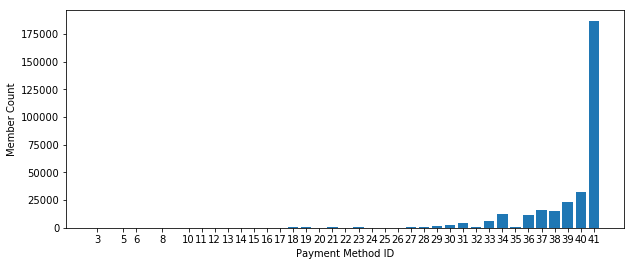

In [20]:
pmi = trans_detail.groupby(['payment_method_id'], as_index=False)['msno'].count()
plt.figure(figsize=(10,4))
plt.bar(pmi.payment_method_id, pmi.msno)
plt.xlabel('Payment Method ID')
plt.xticks(np.array(pmi.payment_method_id))
plt.ylabel('Member Count')

The majority of transactions are for 30 day plans, but they can also range up to 450 days (15 months). It is also popular for users to take a 7-day free trial.

In [21]:
trans_detail.payment_plan_days.describe().round(1)

count    318261.0
mean         29.8
std          16.4
min           0.0
25%          30.0
50%          30.0
75%          30.0
max         450.0
Name: payment_plan_days, dtype: float64

Plan prices are in Taiwanese dollars. The list price for 30 days plans is usually \$149, so we see \$149 listed as the 50th and 75th percentiles of both `plan_list_price` and `actual_amount_paid`. Plans generally get more expensive as they get longer, and the most expensive plan (\$2,000) was for 400 days. In general, the amount people actually paid for their streaming plans is the same as the list price. However, we were surprised to see the mean payment is actually slightly larger than the mean list price, when we expected the reverse due to discounts and sales.

In [22]:
trans_detail[['plan_list_price','actual_amount_paid']].describe().round(1)

,plan_list_price,actual_amount_paid
count,318261.0,318261.0
mean,131.8,136.2
std,74.0,70.8
min,0.0,0.0
25%,99.0,99.0
50%,149.0,149.0
75%,149.0,149.0
max,2000.0,2000.0


The transaction dates fall in the expected range (1/1/2015 - 2/28/2017). Our new expiration dates also start on 1/1/15, but they extend past the end of the transaction period because some users have long payment plan periods.

In [23]:
pd.concat([pd.to_datetime(trans_detail.transaction_date, format='%Y%m%d'),
           pd.to_datetime(trans_detail.new_expire_date, format='%Y%m%d')], axis=1).describe()

,transaction_date,new_expire_date
count,318261,318261
unique,790,851
top,2017-01-31 00:00:00,2017-02-28 00:00:00
freq,3703,2566
first,2015-01-01 00:00:00,2015-01-01 00:00:00
last,2017-02-28 00:00:00,2017-10-23 00:00:00


+ The overwhelming majority of transactions are set to auto-renew.
+ A very small number of transactions are cancellation transactions, which can happen for one of two reasons:
    1. The user is cancelling their membership.
    2. The user is changing some aspect of their membership. (We will calculate later whether a cancellation transaction falls into this category.)
+ Approximately one in five transactions meet our definition of a late payment.

In [24]:
print('''{}

{}

{}'''.format(trans_detail.is_auto_renew.value_counts(normalize=True, dropna=False).round(4),
             trans_detail.is_cancel.value_counts(normalize=True, dropna=False).round(4),
             trans_detail.is_late.value_counts(normalize=True).round(4)))

1    0.9251
0    0.0749
Name: is_auto_renew, dtype: float64

0    0.9824
1    0.0176
Name: is_cancel, dtype: float64

False    0.8196
True     0.1804
Name: is_late, dtype: float64


**Aggregate transactions into one record per member.**

We aggregate the transaction variables in several ways so we can get 1 row per user, which can be merged with the member dataset. We get the following:
+ The last transaction for each member, which tells us:
    + Last transaction date and last expiration date
    + Whether the last transaction was on auto-renew
    + Whether the last transaction was cancelled
+ For each member, counts of:
    + Non-cancelled transactions
    + Cancelled transactions
    + Transactions with payment > 0
+ For each member, percent of transactions that are:
    + In each payment method ID category
    + In each payment plan days category
    + Set to auto-renew
    + Late payments
+ The sum of plan days, list prices, and actual payments for each member, which are used in a later calculation
+ The date of each member's *first* cancelled transaction (if applicable), which is used in a later calculation

In [25]:
# Information about last transaction
def get_latest_trans(df):
    subset = df[['msno','transaction_date','new_expire_date','registration_init_time',
                 'payment_plan_days','is_auto_renew','is_cancel']]
    latest_trans = subset.sort_values(by=['msno','transaction_date','new_expire_date']).groupby(['msno'], as_index=False).last()
    latest_trans.columns = latest_trans.rename(columns={'transaction_date': 'last_transaction',
                                                        'new_expire_date': 'last_expiration',
                                                        'registration_init_time': 'registration_date',
                                                        'payment_plan_days': 'last_plan_days',
                                                        'is_auto_renew': 'latest_trans_auto_renew',
                                                        'is_cancel': 'latest_trans_cancel'
                                                       }).columns
    del subset
    return latest_trans

# Split some variables into dummies and then take the mean of each to get % transactions in each category
def get_dummies(df):
    dummies = pd.concat([df.msno,
                         pd.get_dummies(df.payment_plan_days, prefix='pct_plan_days'),
                         pd.get_dummies(df.payment_method_id, prefix='pct_pmt_method')
                        ], axis=1).groupby(['msno'], as_index=False).mean()
    return dummies

# Aggregate on all transactions
def agg_all_trans(df):
    aggs = df.groupby(['msno'], as_index=False).agg({
        'is_auto_renew': 'mean',
        'is_cancel': sum
    })
    aggs.columns = aggs.rename(columns={'is_auto_renew': 'pct_auto_renew',
                                        'is_cancel': 'count_cancel_trans'
                                       }).columns
    return aggs

# Aggregate on cancelled transactions
def agg_cancelled_trans(df):
    aggs_cancelled = df[df.is_cancel == 1].groupby(['msno'], as_index=False).agg({
        'new_expire_date': min
    })
    aggs_cancelled.columns = aggs_cancelled.rename(columns={'new_expire_date': 'expire_on_first_cancel'
                                                           }).columns
    return aggs_cancelled

# Aggregate on non-cancelled transactions
def agg_non_cancel_trans(df):
    aggs_no_cancel = df[df.is_cancel == 0].groupby(['msno'], as_index=False).agg({
        'actual_amount_paid': sum,
        'is_late': 'mean',
        'payment_plan_days': sum,
        'plan_list_price': sum,
        'transaction_date': 'count'
    })
    aggs_no_cancel.columns = aggs_no_cancel.rename(columns={'actual_amount_paid': 'sum_amt_paid',
                                                            'is_late': 'pct_late_pmt',
                                                            'payment_plan_days': 'sum_plan_days',
                                                            'plan_list_price': 'sum_list_price',
                                                            'transaction_date': 'count_non_cancel_trans'
                                                           }).columns
    return aggs_no_cancel

# Aggregate on transactions with a payment > 0
def agg_trans_with_pmt(df):
    aggs_w_pmt = df[df.actual_amount_paid > 0].groupby(['msno'], as_index=False).agg({
        'actual_amount_paid': 'count'
    })
    aggs_w_pmt.columns = aggs_w_pmt.rename(columns={'actual_amount_paid': 'count_trans_w_payment'
                                                   }).columns
    return aggs_w_pmt

def merge_transaction_aggregations(df):
    # Get pieces to aggregate
    aggs = agg_all_trans(df)
    aggs_cancelled = agg_cancelled_trans(df)
    aggs_no_cancel = agg_non_cancel_trans(df)
    aggs_w_pmt = agg_trans_with_pmt(df)
    latest_trans = get_latest_trans(df)
    dummies = get_dummies(df)

    # Merge
    trans_one_line = pd.merge(aggs, aggs_cancelled, on='msno', how='left')
    trans_one_line = pd.merge(trans_one_line, aggs_no_cancel, on='msno', how='left')
    trans_one_line = pd.merge(trans_one_line, aggs_w_pmt, on='msno', how='left')
    trans_one_line = pd.merge(trans_one_line, latest_trans, on='msno', how='left')
    trans_one_line = pd.merge(trans_one_line, dummies, on='msno', how='left')
    
    return trans_one_line

trans_aggregated = merge_transaction_aggregations(trans_detail)

Now we add some additional variables:
+ Customer lifetime: latest expiration date - registration date
+ Days since last transaction: 2/28/2017 - latest transaction date
+ Average daily list price: SUM(list price) / SUM(plan days)
+ Average daily discount: SUM(amount paid - list price) / SUM(plan days)
+ Switched membership: indicator if the member has *ever* changed their membership; occurs when the expiration date on the user's first cancelled transaction is *earlier than* their latest expiration date

Then we clean up the file by dropping some variables that are no longer needed after making the above calculations:
+ The sums of list price, plan days, and amount paid
+ Expiration date on first cancelled transaction
+ Registration date and last expiration date
+ Last transaction date

In [26]:
# Clean up aggregated transaction files

def clean_trans_summary(df, period_end):
    # Replace NaN with 0 in some columns
    df['count_non_cancel_trans'] = df['count_non_cancel_trans'].apply(lambda x: int(x) if x > 0 else 0)
    df['count_trans_w_payment'] = df['count_trans_w_payment'].apply(lambda x: int(x) if x > 0 else 0)

    # Add some variables
    df['customer_lifetime'] = pd.to_datetime(df['last_expiration'], format='%Y%m%d').sub(pd.to_datetime(df['registration_date'], format='%Y%m%d')).dt.days
    df['days_since_last_trans'] = df['last_transaction'].apply(lambda x: (pd.to_datetime(period_end, format='%Y%m%d') - pd.to_datetime(x, format='%Y%m%d')).days)
    df['avg_daily_list_price'] = df['sum_list_price'] / df['sum_plan_days']
    df['avg_daily_discount'] = (df['sum_amt_paid'] / df['sum_plan_days']) - df['avg_daily_list_price']
    df['switched_membership'] = (df['last_expiration'] > df['expire_on_first_cancel']).apply(lambda x: 1 if x is True else 0)
    

    # Drop unneeded variables
    df = df.drop(['sum_list_price','sum_amt_paid','sum_plan_days','expire_on_first_cancel',
                  'registration_date','last_transaction','last_expiration'], axis=1)
    
    return df

trans_aggregated = clean_trans_summary(trans_aggregated, 20170228)

Now our aggregated data has 20,000 rows -- one for each user -- and a number of features describing the transaction history of that user.

In [27]:
print (trans_aggregated.shape)
trans_aggregated.head()

(20000, 78)


,msno,pct_auto_renew,count_cancel_trans,count_non_cancel_trans,pct_late_pmt,count_trans_w_payment,last_plan_days,latest_trans_auto_renew,latest_trans_cancel,pct_plan_days_0,...,pct_pmt_method_37,pct_pmt_method_38,pct_pmt_method_39,pct_pmt_method_40,pct_pmt_method_41,customer_lifetime,days_since_last_trans,avg_daily_list_price,avg_daily_discount,switched_membership
0,++5BmBHS2ebe4Whfg/7KhGkj/sQ6rtNHsktLxsI01KE=,1.0,0,15,0.266667,15,30,1,0,0.0,...,0.0,0.0,1.0,0.0,0.0,1457.0,28,4.966667,0.0,0
1,++aFrWPzVzGo/Q0I1nze64DYFOAD8kneadlQKmmYTjA=,1.0,0,9,0.111111,9,30,1,0,0.0,...,0.0,0.0,0.0,0.0,1.0,NaN,0,3.300000,0.0,0
2,+/1EDtwrn7StJp1C1SZWgbawUVFH2sWreBSTaFsv3lo=,1.0,0,3,0.666667,3,30,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,22,4.300000,0.0,0
3,+/fLVvbupWg/9UysOyhPUQfGDQYKuWxSyuTEUk/n3iw=,1.0,1,27,0.037037,28,30,1,0,0.0,...,0.0,0.0,0.0,0.0,1.0,789.0,11,4.670370,0.0,1
4,+/jSNRMnEqElT4tO+UpL6aXwHLCXMLOy5nCa4Kic6rI=,1.0,0,5,0.000000,5,30,1,0,0.0,...,0.0,0.0,0.0,0.0,1.0,150.0,1,3.300000,0.0,0


### User Logs
Finally we review the filtered user logs file. Each record of the log file gives us information about how many songs were listened to, and for how long, on a day that the user logged in (i.e. there are no records for days where the user did not log in). A small number of users don't have any user log information (meaning they paid for the service but never used it), but the majority do, and many users actually have hundreds of user logs during the time period we are reviewing. Just as in the case of members, we account for missing data with an additional binary feature for user log data missing.

In [28]:
unq_msno = logs_detail.msno.nunique()
print ('''Unique Number of Members in User Logs File: {:,}'''.format(unq_msno))
print ('''Average User Logs per Member: {:.1f}'''.format(len(logs_detail) / unq_msno))
logs_detail.head()

Unique Number of Members in User Logs File: 17,536
Average User Logs per Member: 280.7


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,OcZ3fKQzHrL1BuzuFRzUiwPr8l9P8JKCFpafdYf5sCY=,20150220,0,0,0,1,6,7,1597.062
1,OcZ3fKQzHrL1BuzuFRzUiwPr8l9P8JKCFpafdYf5sCY=,20150419,0,0,0,1,7,5,2106.230
2,OcZ3fKQzHrL1BuzuFRzUiwPr8l9P8JKCFpafdYf5sCY=,20150614,1,1,0,0,6,3,1592.724
3,OcZ3fKQzHrL1BuzuFRzUiwPr8l9P8JKCFpafdYf5sCY=,20150806,1,2,2,1,37,43,10355.986
4,OcZ3fKQzHrL1BuzuFRzUiwPr8l9P8JKCFpafdYf5sCY=,20151005,6,1,0,0,24,16,5923.856


We add a `YearMonth` variable to the user log data, which we will use for aggregating by month.

In [29]:
# Transformations to user log data
logs_detail['date'] = pd.to_datetime(logs_detail['date'], format='%Y%m%d')
logs_detail['YearMonth'] = logs_detail['date'].map(lambda x: 100*x.year + x.month)

# See user logs detail
logs_detail.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,YearMonth
0,OcZ3fKQzHrL1BuzuFRzUiwPr8l9P8JKCFpafdYf5sCY=,2015-02-20,0,0,0,1,6,7,1597.062,201502
1,OcZ3fKQzHrL1BuzuFRzUiwPr8l9P8JKCFpafdYf5sCY=,2015-04-19,0,0,0,1,7,5,2106.230,201504
2,OcZ3fKQzHrL1BuzuFRzUiwPr8l9P8JKCFpafdYf5sCY=,2015-06-14,1,1,0,0,6,3,1592.724,201506
3,OcZ3fKQzHrL1BuzuFRzUiwPr8l9P8JKCFpafdYf5sCY=,2015-08-06,1,2,2,1,37,43,10355.986,201508
4,OcZ3fKQzHrL1BuzuFRzUiwPr8l9P8JKCFpafdYf5sCY=,2015-10-05,6,1,0,0,24,16,5923.856,201510


All the user logs fall within the expected dates of 1/1/2015 to 2/28/2017.

In [30]:
logs_detail.date.describe()

count                 4922563
unique                    790
top       2017-01-26 00:00:00
freq                     9386
first     2015-01-01 00:00:00
last      2017-02-28 00:00:00
Name: date, dtype: object

The `num_XX` variables describe how many songs the user listened to that day, where the number in the variable name corresponds to the percentage of the song listened to (i.e. `num_25` is the number of songs listened to 0-25% of the way through). `num_unq` is the number of unique songs listened to. On the median login, the user listens to 4,644 seconds of music (1 hour and 17 minutes), and 19 unique songs.

In [31]:
# 'Maybe we dont need this, enough to do on aggregated logs_detail'

#plt.figure(figsize=(15, 12))

# Iterate over the features, creating a subplot with a histogram for each one.
#for feature in range(2,logs_detail.shape[1]-1):
#    plt.subplot(3,3, feature)
#    print(feature, logs_detail.columns[feature])
#    plt.hist(logs_detail[logs_detail.columns[feature]], 20)
#    plt.title(logs_detail.columns[feature])

logs_detail.drop(['msno','date'], axis=1).describe().round(1)

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,YearMonth
count,4922563.0,4922563.0,4922563.0,4922563.0,4922563.0,4922563.0,4922563.0,4922563.0
mean,6.4,1.6,1.0,1.1,30.8,30.1,8110.4,201581.3
std,13.4,4.1,2.1,2.5,40.1,33.3,9767.3,62.0
min,0.0,0.0,0.0,0.0,0.0,1.0,0.0,201501.0
25%,0.0,0.0,0.0,0.0,7.0,8.0,1948.4,201509.0
50%,2.0,1.0,0.0,0.0,17.0,19.0,4644.4,201604.0
75%,7.0,2.0,1.0,1.0,38.0,39.0,10171.1,201610.0
max,1862.0,491.0,269.0,532.0,2045.0,1150.0,86399.4,201702.0


Now we will aggregate the user logs into a single record per user. We aggregate at 3 levels:
1. Per user:
    + Total number of logins
2. Per user per month:
    + Average logins per month
3. Per user per login:
    + Average # songs listened to 0-25% of the way through per login
    + Average # songs listened to 26-50% of the way through per login
    + Average # songs listened to 51-75% of the way through per login
    + Average # songs listened to 76-98.5% of the way through per login
    + Average # songs listened to 98.5-100% of the way through per login
    + Average # unique songs listened to per login
    + Average total seconds of music per login

In [32]:
# Aggregate user log data

# Get average logins per month
avg_monthly_logs = logs_detail.groupby(by=['msno','YearMonth'], as_index=False)['date'].count()
avg_monthly_logs = avg_monthly_logs.groupby(['msno'], as_index=False)['date'].mean()
avg_monthly_logs.columns = avg_monthly_logs.rename(columns={'date': 'avg_monthly_logs'}).columns

# Aggregate some login information by user
agg_by_user = logs_detail.groupby(by=['msno'], as_index=False).agg({
    'date': 'count',
    'num_25': 'mean',
    'num_50': 'mean',
    'num_75': 'mean',
    'num_985': 'mean',
    'num_100': 'mean',
    'num_unq': 'mean',
    'total_secs': 'mean'
})
agg_by_user.columns = agg_by_user.rename(columns={'date': 'total_logins',
                                                  'num_25': 'avg_num_25',
                                                  'num_50': 'avg_num_50',
                                                  'num_75': 'avg_num_75',
                                                  'num_985': 'avg_num_985',
                                                  'num_100': 'avg_num_100',
                                                  'num_unq': 'avg_num_unq',
                                                  'total_secs': 'avg_total_secs'
                                                 }).columns

# Merge aggregated datasets
logs_aggregated = pd.merge(agg_by_user, avg_monthly_logs, on='msno', how='left')
del avg_monthly_logs, agg_by_user

The aggregated logs give us information for 17,536 of the users in our set of 20,000.

In [33]:
print (logs_aggregated.shape)
logs_aggregated.head()

(17536, 10)


,msno,avg_num_985,avg_num_50,avg_total_secs,avg_num_25,avg_num_75,avg_num_unq,total_logins,avg_num_100,avg_monthly_logs
0,++5BmBHS2ebe4Whfg/7KhGkj/sQ6rtNHsktLxsI01KE=,0.495868,1.103306,2340.745037,3.260331,0.764463,11.652893,242,7.987603,11.000000
1,+/fLVvbupWg/9UysOyhPUQfGDQYKuWxSyuTEUk/n3iw=,0.658249,0.749158,13633.042589,1.868687,0.569024,42.752525,594,54.121212,22.846154
2,+/jSNRMnEqElT4tO+UpL6aXwHLCXMLOy5nCa4Kic6rI=,0.677419,1.193548,5492.172323,7.225806,1.032258,25.483871,31,19.870968,6.200000
3,+0GTEEgfgwMjhIF9RJqCOQCaWUQeNKMRyj02XbLFJzI=,0.403509,0.973684,2960.805026,3.850877,0.508772,12.640351,114,10.043860,9.500000
4,+0NnoDS9yGuq0gehgigylB3mNMRdOEDtLa6SnC0v3+w=,0.666667,0.752874,2921.265316,4.114943,0.568966,9.488506,174,10.488506,10.235294


The histograms below show the distributions of the average song count variables, average total seconds, average monthly logins, and total logins. The song count variables are all skewed right, as are average total seconds and average total logins. Logins per month ranges from 1 to 30.

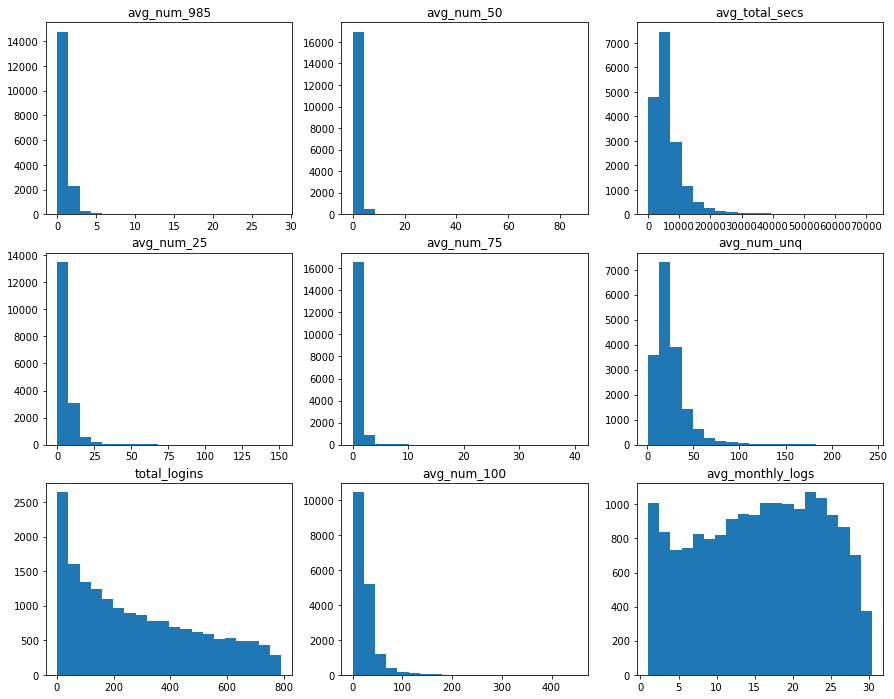

In [34]:
plt.figure(figsize=(15, 12))

# Iterate over the features, creating a subplot with a histogram for each one.
for feature in range(1, logs_aggregated.shape[1]):
    plt.subplot(3, 3, feature)
    #print(feature, logs_aggregated.columns[feature])
    plt.hist(logs_aggregated[logs_aggregated.columns[feature]], 20)
    plt.title(logs_aggregated.columns[feature])

# Prepare Data For Model

### Merge Data and Split into Train & Test
We now merge our four data sources: members, aggregated transactions, aggregated user logs, and the churn labels. The transactions are left joined to members and user logs since every user has transaction data. The final data is shown below.

In [35]:
# Merge members, transactions, user logs, and churn information
final_data = pd.merge(trans_aggregated, members.drop('registration_init_time', axis=1), on='msno', how='left')
final_data = pd.merge(final_data, logs_aggregated, on='msno', how='left')
final_data = pd.merge(final_data, churn_labels, on='msno', how='inner')

print (final_data.shape)
final_data.head()

(20000, 94)


,msno,pct_auto_renew,count_cancel_trans,count_non_cancel_trans,pct_late_pmt,count_trans_w_payment,last_plan_days,latest_trans_auto_renew,latest_trans_cancel,pct_plan_days_0,...,avg_num_985,avg_num_50,avg_total_secs,avg_num_25,avg_num_75,avg_num_unq,total_logins,avg_num_100,avg_monthly_logs,is_churn
0,++5BmBHS2ebe4Whfg/7KhGkj/sQ6rtNHsktLxsI01KE=,1.0,0,15,0.266667,15,30,1,0,0.0,...,0.495868,1.103306,2340.745037,3.260331,0.764463,11.652893,242.0,7.987603,11.000000,0
1,++aFrWPzVzGo/Q0I1nze64DYFOAD8kneadlQKmmYTjA=,1.0,0,9,0.111111,9,30,1,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,+/1EDtwrn7StJp1C1SZWgbawUVFH2sWreBSTaFsv3lo=,1.0,0,3,0.666667,3,30,1,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,+/fLVvbupWg/9UysOyhPUQfGDQYKuWxSyuTEUk/n3iw=,1.0,1,27,0.037037,28,30,1,0,0.0,...,0.658249,0.749158,13633.042589,1.868687,0.569024,42.752525,594.0,54.121212,22.846154,0
4,+/jSNRMnEqElT4tO+UpL6aXwHLCXMLOy5nCa4Kic6rI=,1.0,0,5,0.000000,5,30,1,0,0.0,...,0.677419,1.193548,5492.172323,7.225806,1.032258,25.483871,31.0,19.870968,6.200000,0


Next we break off the `is_churn` variable into its own dataframe so it can serve as our target (predicted) variable.

In [36]:
# Break is_churn off into its own dataframe
final_labels = final_data.is_churn
final_data = final_data.drop('is_churn', axis=1)

print (final_data.shape)
print (final_labels.shape)

(20000, 93)
(20000,)


Finally, we split the data into a train, dev, and test set. The dev set will help us tune our model before we apply it to our test data.

In [37]:
split1 = int(len(final_data) * 0.75)
split2 = int(len(final_data) * 0.8)

# Train-test split
test_data, test_labels = final_data[split2:], final_labels[split2:]
dev_data, dev_labels = final_data[split1:split2], final_labels[split1:split2]
train_data, train_labels = final_data[:split1], final_labels[:split1]

print ('Train:', train_data.shape, train_labels.shape)
print ('Dev:', dev_data.shape, dev_labels.shape)
print ('Test:', test_data.shape, test_labels.shape)

Train: (15000, 93) (15000,)
Dev: (1000, 93) (1000,)
Test: (4000, 93) (4000,)


### Pipeline

The final step to prepare our data for modeling is to impute missing values and normalize everything. We will apply different types of processing to different types of variables, so the first step is to split the predictors into different types: numeric, categorical, binary, and datetime. Note that our datetime predictor list is empty; although we created a pipeline for this type of variable, we did not ultimately include any datetime features in our final data.

In [38]:
final_data.columns

Index(['msno', 'pct_auto_renew', 'count_cancel_trans',
       'count_non_cancel_trans', 'pct_late_pmt', 'count_trans_w_payment',
       'last_plan_days', 'latest_trans_auto_renew', 'latest_trans_cancel',
       'pct_plan_days_0', 'pct_plan_days_1', 'pct_plan_days_3',
       'pct_plan_days_7', 'pct_plan_days_10', 'pct_plan_days_14',
       'pct_plan_days_21', 'pct_plan_days_30', 'pct_plan_days_31',
       'pct_plan_days_35', 'pct_plan_days_60', 'pct_plan_days_66',
       'pct_plan_days_70', 'pct_plan_days_90', 'pct_plan_days_100',
       'pct_plan_days_110', 'pct_plan_days_120', 'pct_plan_days_180',
       'pct_plan_days_195', 'pct_plan_days_200', 'pct_plan_days_240',
       'pct_plan_days_270', 'pct_plan_days_360', 'pct_plan_days_365',
       'pct_plan_days_395', 'pct_plan_days_400', 'pct_plan_days_410',
       'pct_plan_days_450', 'pct_pmt_method_3', 'pct_pmt_method_5',
       'pct_pmt_method_6', 'pct_pmt_method_8', 'pct_pmt_method_10',
       'pct_pmt_method_11', 'pct_pmt_method_12',

In [39]:
# Names of data features
predictors_numeric = ['bd','registration_month', # from members
                      'count_cancel_trans','count_non_cancel_trans','count_trans_w_payment', # from transactions
                      'pct_auto_renew','pct_late_pmt','last_plan_days', # from transactions
                      'pct_plan_days_0','pct_plan_days_1','pct_plan_days_3', # from transactions
                      'pct_plan_days_7','pct_plan_days_10','pct_plan_days_14', # from transactions
                      'pct_plan_days_21','pct_plan_days_30','pct_plan_days_31', # from transactions
                      'pct_plan_days_35','pct_plan_days_60','pct_plan_days_66', # from transactions
                      'pct_plan_days_70','pct_plan_days_90','pct_plan_days_100', # from transactions
                      'pct_plan_days_110','pct_plan_days_120','pct_plan_days_180', # from transactions
                      'pct_plan_days_195','pct_plan_days_200','pct_plan_days_240', # from transactions
                      'pct_plan_days_270','pct_plan_days_360','pct_plan_days_365', # from transactions
                      'pct_plan_days_395','pct_plan_days_400','pct_plan_days_410', # from transactions
                      'pct_plan_days_450','pct_pmt_method_3','pct_pmt_method_5', # from transactions
                      'pct_pmt_method_6','pct_pmt_method_8','pct_pmt_method_10', # from transactions
                      'pct_pmt_method_11','pct_pmt_method_12','pct_pmt_method_13', # from transactions
                      'pct_pmt_method_14','pct_pmt_method_15','pct_pmt_method_16', # from transactions
                      'pct_pmt_method_17','pct_pmt_method_18','pct_pmt_method_19', # from transactions
                      'pct_pmt_method_20','pct_pmt_method_21','pct_pmt_method_22', # from transactions
                      'pct_pmt_method_23','pct_pmt_method_24','pct_pmt_method_25', # from transactions
                      'pct_pmt_method_26','pct_pmt_method_27','pct_pmt_method_28', # from transactions
                      'pct_pmt_method_29','pct_pmt_method_30','pct_pmt_method_31', # from transactions
                      'pct_pmt_method_32','pct_pmt_method_33','pct_pmt_method_34', # from transactions
                      'pct_pmt_method_35','pct_pmt_method_36','pct_pmt_method_37', # from transactions
                      'pct_pmt_method_38','pct_pmt_method_39','pct_pmt_method_40', # from transactions
                      'pct_pmt_method_41','customer_lifetime','days_since_last_trans', # from transactions
                      'avg_daily_list_price','avg_daily_discount', # from transactions
                      'avg_num_25','avg_num_50','avg_num_75','avg_num_985','avg_num_100', # from user logs
                      'avg_num_unq','avg_total_secs','avg_monthly_logs','total_logins'] # from user logs
predictors_categorical = ['city','gender','registered_via','member_profile_complete'] # from members
predictors_binary = ['latest_trans_auto_renew','latest_trans_cancel','switched_membership'] # from transactions
predictors_datetime = []

In [40]:
# Check we included all needed variables in the lists above
# --> should be one less than what's in final_data because we don't need 'msno'
len(predictors_numeric) + len(predictors_categorical) + len(predictors_binary) + len(predictors_datetime)

92

Next we create each pipeline. The numeric pipeline selects the columns of numeric predictors from the dataframe, imputes any missing values as the mean of the column, and then normalizes everything.

In [41]:
# Numerical pipeline
def select_numeric_features(X):
    return X[predictors_numeric]

pipeline_numeric = Pipeline(steps=[
    ('select', FunctionTransformer(select_numeric_features, validate=False)),
    ('impute', Imputer(strategy='mean')),
    ('scale', StandardScaler())
])

The pipeline for categorical variables selects the categorical predictors and converts any non-string columns to strings. It then creates a dictionary of all possible values in the row (e.g. in the case of gender, after converting all values to strings, the dictionary will consist of 'male', 'female', and 'nan'). The pipeline then creates a binary variable for each value in the dictionary, so gender will be transformed into three binary columns: 'gender=male', 'gender=female', and 'gender=nan'.

In [42]:
# Categorical pipeline
def select_categorical_features(X):
    return X[predictors_categorical]

def ensure_datatype(X):
    return X.apply(lambda col: col.astype(str))

def make_dictionaries(X):
    return X.to_dict(orient='records')

pipeline_categorical = Pipeline(steps=[
    ('select', FunctionTransformer(select_categorical_features, validate=False)),
    ('dtype', FunctionTransformer(ensure_datatype, validate=False)),
    ('dict', FunctionTransformer(make_dictionaries, validate=False)),
    ('vectorize', DictVectorizer(sparse=False))
])

Our binary pipeline simply selects binary features and imputes missing values with the mode. We do not include these variables in the categorical pipeline because they have already been "vectorized" into binary features.

In [43]:
# Binary pipeline
def select_binary_features(X):
    return X[predictors_binary]

pipeline_binary = Pipeline(steps=[
    ('select', FunctionTransformer(select_binary_features, validate=False)),
    ('impute', Imputer(strategy='most_frequent'))
])

Finally, the datetime pipeline selects all datetime features, which are all formatted as YYYYMMDD integers in our data. Since this type of formatting makes the dates non-continuous (e.g. there are no values between 20151231 and 20160101), the pipeline converts everything to datetime to make it continuous. However, we can't calculate mean and standard deviation on datetime variables, so we make a second transformation to the ordinal numbers corresponding to each date. Then we can impute the missing values as the mean and apply standard scaling.

In [44]:
# Datetime pipeline
def select_datetime_features(X):
    return X[predictors_datetime]

def number_to_datetime(X):
    X2 = pd.DataFrame()
    for i in range(X.shape[1]):
        col = X.columns[i]
        X2[col] = pd.to_datetime(X[col], format='%Y%m%d')
    return X2

def datetime_to_ordinal(X):
    X2 = pd.DataFrame()
    for i in range(X.shape[1]):
        col = X.columns[i]
        X2[col] = X[col].map(dt.datetime.toordinal).replace(1, np.NaN)
    return X2

pipeline_datetime = Pipeline(steps=[
    ('select', FunctionTransformer(select_datetime_features, validate=False)),
    ('to_date', FunctionTransformer(number_to_datetime, validate=False)),
    ('to_ordinal', FunctionTransformer(datetime_to_ordinal, validate=False)),
    ('impute', Imputer(strategy='mean')),
    ('scale', StandardScaler())
])

The four pipelines are combined into a feature union. The datetime feature is commented out since we have not included any datetime features.

In [45]:
# Unite all pipelines
feature_union = FeatureUnion([('numeric', pipeline_numeric),
                              ('categorical', pipeline_categorical),
                              ('binary', pipeline_binary)#,
                              #('datetime', pipeline_datetime)
                             ])

### Fit Pipeline and Use It To Transform All Data
Now we fit the pipeline to the training data and use the fitted pipeline to transform the training, dev, and test data. The transformed data consists entirely of normalized or binarized variables and has no missing values (an example row is shown below). This transformed data is what we will use in our model.

In [46]:
train_data_transformed = feature_union.fit_transform(train_data)
dev_data_transformed = feature_union.fit(train_data).transform(dev_data)
test_data_transformed = feature_union.fit(train_data).transform(test_data)

In [47]:
print ('Train data:', train_data_transformed.shape)
print ('Dev data:', dev_data_transformed.shape)
print ('Test data:', test_data_transformed.shape)

Train data: (15000, 122)
Dev data: (1000, 122)
Test data: (4000, 122)


In [48]:
# Example row
train_data_transformed[0].round(4)

array([ 0.    , -1.0769, -0.474 , -0.0824, -0.0996,  0.4036,  0.246 ,
       -0.1251, -0.4217, -0.0376, -0.0082, -0.1426, -0.0333, -0.0216,
       -0.0111,  0.5068, -0.3937, -0.0108, -0.0305,  0.    , -0.0082,
       -0.0526, -0.0469, -0.0082, -0.0567, -0.054 , -0.098 , -0.0256,
       -0.0193, -0.0113, -0.0238, -0.0082, -0.0294, -0.0188, -0.0953,
       -0.0082,  0.    , -0.0082, -0.0082, -0.0082, -0.0115, -0.0082,
       -0.0236, -0.021 , -0.0183, -0.0101, -0.0277, -0.0357, -0.0337,
       -0.0339, -0.0472, -0.0355, -0.0425, -0.0427, -0.0405, -0.0352,
       -0.0376, -0.0499, -0.0608, -0.1244, -0.1282, -0.0981, -0.1144,
       -0.1248, -0.1765, -0.1524, -0.2655, -0.2117, -0.2963,  3.7734,
       -0.3083, -1.1739,  0.1686,  0.1435,  0.7643, -0.2485, -0.4628,
       -0.2561, -0.174 , -0.5354, -0.7883, -0.8407, -0.8296, -0.603 ,
       -0.1947,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0. 

# Model Selection, Fit and Evaluation 

Having identified the KKBox requirement as a supervised learning problem from the outset, we now fit three such  models on the final dataset -- K-Nearest Neighbors, Bernoulli Naive Bayes as well as Logistic Regression. In each case the feature matrix is the set of attributes we have collected from transforming the attributes in KKBox's original files. This makes for 122 features in total. The target or Y-variable is the `is_churn` attribute taken from the KKBox train file. A value of 1 means the customer has churned as of February 2017 and 0 means the customer has renewed their subscription.

Given the large number of features, we attempt to reduce dimensionality using Principal Components Analysis (PCA) in two ways. First we take the complete set of features and project them all to a specific number of components before feeding the data into the model. Alternatively, we take groupings of features that are naturally most related to one another and separately project them into fewer components before feeding into the model. This results in three different model specifications based on what comprises the feature matrix, namely:

 + All 122 features from Transformed Data 
 + PCA on all features at once
 + Multiple, independent PCA on groups of naturally related features

### Create PCA and Partial PCA Datasets
Before defining the models, we generate the feature matrices with complete PCA (with all features) and partial PCA (with groups of related features).

(0, 1)

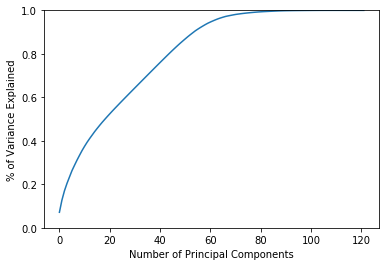

In [49]:
# PCA on everything

# Project to principle components
max_components = train_data_transformed.shape[1]
pca = PCA(n_components=max_components)
pca.fit(train_data_transformed, train_labels)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('% of Variance Explained')
plt.ylim(0,1)

 Complete PCA shows that 90% of total variance is explained by 55 components. 

In [50]:
# Number of components needed to get 90% of variance explained
n_pca = np.sum(np.cumsum(pca.explained_variance_ratio_) < 0.9) + 1
print ('Components:', n_pca)

# Project everything to n_pca components
pca = PCA(n_components=n_pca)
pca.fit(train_data_transformed, train_labels)

pca_train = pca.transform(train_data_transformed)
pca_dev = pca.transform(dev_data_transformed)
pca_test = pca.transform(test_data_transformed)

Components: 55


In [51]:
print ('PCA train data:', pca_train.shape)
print ('PCA dev data:', pca_dev.shape)
print ('PCA test data:', pca_test.shape)

PCA train data: (15000, 55)
PCA dev data: (1000, 55)
PCA test data: (4000, 55)


Next we perform partial PCA based on the following groupings:
+ **Userlogs Components**: this consists of all aggregated user log information including number of unique songs, total seconds as well as averages of the length the song was played. We collapse a total of 9 attributes into 2 components. 
+ **Percent Payment Method Components**: collapses the 36 features describing payment method type into 4 components. 
+ **Percent Payment Plan Days Components**: collapses the 29 features describing payment plan days into 4 components. 
+ **Transaction Counts Components**: this includes the count of transactions in which the member cancelled his/her subscription, count of transactions which are _not_ cancellations, and the count of transactions in which the customer paid some amount greater than 0.

In [52]:
# PCA on a few specific components

# 9 columns to 2 components -- user logs
c1 = range(predictors_numeric.index('avg_num_25'), predictors_numeric.index('total_logins')+1)

# 36 columns to 4 components -- % payment method columns
c2 = range(predictors_numeric.index('pct_pmt_method_3'), predictors_numeric.index('pct_pmt_method_41')+1)

# 29 columns to 4 components -- % plan days columns
c3 = range(predictors_numeric.index('last_plan_days'), predictors_numeric.index('pct_plan_days_450')+1)

# 3 columns to 1 component -- transaction counts (cancelled, non-cancelled, with payment >0)
c4 = range(predictors_numeric.index('count_cancel_trans'), predictors_numeric.index('count_trans_w_payment')+1)

# This function replaces certain columns from the transformed data with a specified number of components
def create_components(arr, columns, n):
    # Create PCA from the subset of columns
    subset = arr[:, columns]
    pca = PCA(n_components=n)
    pca_subset = pca.fit_transform(subset)
    
    # Drop columns from array
    arr = np.delete(arr, columns, axis=1)
    
    # Append new PCA column
    arr = np.append(arr, pca_subset, axis=1)
    
    return arr

In [53]:
# Train data
partial_pca_train = create_components(train_data_transformed, c1, 2)
partial_pca_train = create_components(partial_pca_train, c2, 4)
partial_pca_train = create_components(partial_pca_train, c3, 4)
partial_pca_train = create_components(partial_pca_train, c4, 1)

# Dev data
partial_pca_dev = create_components(dev_data_transformed, c1, 2)
partial_pca_dev = create_components(partial_pca_dev, c2, 4)
partial_pca_dev = create_components(partial_pca_dev, c3, 4)
partial_pca_dev = create_components(partial_pca_dev, c4, 1)

# Test data
partial_pca_test = create_components(test_data_transformed, c1, 2)
partial_pca_test = create_components(partial_pca_test, c2, 4)
partial_pca_test = create_components(partial_pca_test, c3, 4)
partial_pca_test = create_components(partial_pca_test,c4,1)

In [54]:
print ('Partial PCA train data:', partial_pca_train.shape)
print ('Partial PCA dev data:', partial_pca_dev.shape)
print ('Partial PCA test data:', partial_pca_test.shape)

Partial PCA train data: (15000, 56)
Partial PCA dev data: (1000, 56)
Partial PCA test data: (4000, 56)


### Baseline Statistics for Model Comparison 
Before feeding the processed data into the models, we examine how accurate a model would be if it predicted all customers would renew (that is, `is_churn = 0`). This serves as a baseline for comparing and evaluating the models. 

In [55]:
print ('''Churn in Train Set: {:.1f}%
Churn in Dev Set: {:.1f}%
Model Accuracy if Predict Churn=0 for Everyone: {:.4f}
'''.format(100.0 * np.mean(train_labels), 100.0 * np.mean(dev_labels), 1 - np.mean(dev_labels)))   

Churn in Train Set: 6.5%
Churn in Dev Set: 6.2%
Model Accuracy if Predict Churn=0 for Everyone: 0.9380



## K-Nearest Neighbors

Testing K values between 1 and 20, and running the model on the three datasets, we find that the highest accuracy is reported for no PCA & partial PCA with `k=3` at 0.958. These models perform better than a complete PCA, which results in accuracy of 0.951 at `k=2`.

In [56]:
k = range(1,21)
knn_acc, knn_acc_pca, knn_acc_partial_pca = [], [], []

for i in range(len(k)):
    # Fit on normal data
    knn1 = KNeighborsClassifier(n_neighbors = k[i])
    knn1.fit(train_data_transformed, train_labels)
    knn_acc.append(knn1.score(dev_data_transformed, dev_labels))
    
    # Fit on PCA data
    knn2 = KNeighborsClassifier(n_neighbors = k[i])
    knn2.fit(pca_train, train_labels)
    knn_acc_pca.append(knn2.score(pca_dev, dev_labels))
    
    # Fit on partial PCA data
    knn3 = KNeighborsClassifier(n_neighbors = k[i])
    knn3.fit(partial_pca_train, train_labels)
    knn_acc_partial_pca.append(knn3.score(partial_pca_dev, dev_labels))

In [57]:
print ('''BEST ACCURACIES:
No PCA: {:.3f} where k = {}
Full PCA: {:.3f} where k = {}
Partial PCA: {:.3f} where k = {}
'''.format(max(knn_acc), k[np.where(knn_acc == max(knn_acc))[0][0]],
           max(knn_acc_pca), k[np.where(knn_acc_pca == max(knn_acc_pca))[0][0]],
           max(knn_acc_partial_pca), k[np.where(knn_acc_partial_pca == max(knn_acc_partial_pca))[0][0]]
          ))

BEST ACCURACIES:
No PCA: 0.958 where k = 3
Full PCA: 0.951 where k = 2
Partial PCA: 0.958 where k = 3



Full PCA almost uniformly has the worst performance in terms of accuracy. This is unexpected, considering that lower dimensionality should improve the measurment of distance between neighbors. At lower k-values, Partial PCA works better than No PCA, likely because it reduces dimensionality. 

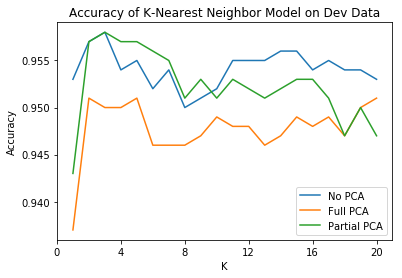

In [58]:
plt.plot(k, knn_acc, label='No PCA')
plt.plot(k, knn_acc_pca, label='Full PCA')
plt.plot(k, knn_acc_partial_pca, label='Partial PCA')
plt.title('Accuracy of K-Nearest Neighbor Model on Dev Data')
plt.xlabel('K')
plt.xticks(np.arange(0, 21, 4))
plt.ylabel('Accuracy')
plt.legend()

We also attempt to find the best performing model through a grid search on the three different data sets. This yields No PCA with `k=9` as the best performing model, with accuracy of 0.9457.

In [59]:
# Grid Search 
params_list= [i for i in range(1,21)]
knn = KNeighborsClassifier()
params = {'n_neighbors': params_list}

knn_searcher1 = GridSearchCV(knn, params)
knn_searcher1.fit(train_data_transformed, train_labels)

knn_searcher2 = GridSearchCV(knn, params)
knn_searcher2.fit(pca_train, train_labels)

knn_searcher3 = GridSearchCV(knn, params)
knn_searcher3.fit(partial_pca_train, train_labels)

print ('''BEST ACCURACIES:
No PCA: {:.4f} with {}
Full PCA: {:.4f} with {}
Partial PCA: {:.4f} with {}
'''.format(knn_searcher1.best_score_, knn_searcher1.best_params_,
           knn_searcher2.best_score_, knn_searcher2.best_params_,
           knn_searcher3.best_score_, knn_searcher3.best_params_))

BEST ACCURACIES:
No PCA: 0.9457 with {'n_neighbors': 9}
Full PCA: 0.9407 with {'n_neighbors': 16}
Partial PCA: 0.9437 with {'n_neighbors': 15}



The accuracy of the best performing model as reported by the grid search is only marginally better than our baseline of accuracy where we predict all individuals as churning. However, when we examine the classification report, we find that the model will fail to identify 69% of customers who are going to churn (False Negatives), and will wrongly identify 1% of renewing customers as churning (False Positives). Despite the false positives, this model still offers some value to KKBox compared to the baseline of assuming that all customers will not churn, because it _does_ manage to identify 31% of churning customers, giving KKBox a chance to take action to retain those customers.

In [60]:
## Classification report on the best performing model
 #(no PCA with k=9)
knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(train_data_transformed, train_labels)
knn_pred = knn.predict(dev_data_transformed)

print(classification_report(dev_labels, knn_pred))

# precision = true pos / (true pos + false pos) -- how many customers ID'd as churning actually churn?
# recall = true pos / (true pos + false neg) -- how many churning customers do we ID as churning?

             precision    recall  f1-score   support

          0       0.96      0.99      0.97       938
          1       0.76      0.31      0.44        62

avg / total       0.94      0.95      0.94      1000



A look at the ROC Curve also shows that the area under the curve is 0.944, which indicates this is a good classifier for identifying customers who will not churn.

0.94365155787880861

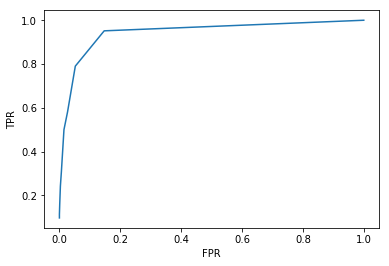

In [61]:
pred = knn.predict_proba(dev_data_transformed)[:, 1]
fpr, tpr, thresh = roc_curve(dev_labels, pred)

plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

roc_auc_score(dev_labels, pred)

##  **Bernoulli Naive Bayes**

To find the best model specification, we train Bernoulli Naive Bayes with different values of alpha for each of the three train datasets, recording accuracy on the dev set. The maximum accuracy for all 3 models is 0.938, which is the same as the baseline accuracy.

In [62]:
alpha = [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
nb_acc, nb_acc_pca, nb_acc_partial_pca = [], [], []

for i in range(len(alpha)):
    # Fit on normal data
    nb1 = BernoulliNB(alpha = alpha[i])
    nb1.fit(train_data_transformed, train_labels)
    nb_acc.append(nb1.score(dev_data_transformed, dev_labels))
    
    # Fit on PCA data
    nb2 = BernoulliNB(alpha = alpha[i])
    nb2.fit(pca_train, train_labels)
    nb_acc_pca.append(nb2.score(pca_dev, dev_labels))
    
    # Fit on partial PCA data
    nb3 = BernoulliNB(alpha = alpha[i])
    nb3.fit(partial_pca_train, train_labels)
    nb_acc_partial_pca.append(nb3.score(partial_pca_dev, dev_labels))

//anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


In [63]:
print ('''BEST ACCURACIES:
No PCA: {:.3f} where alpha = {}
Full PCA: {:.3f} where alpha = {}
Partial PCA: {:.3f} where alpha = {}
'''.format(max(nb_acc), alpha[np.where(nb_acc == max(nb_acc))[0][0]],
           max(nb_acc_pca), alpha[np.where(nb_acc_pca == max(nb_acc_pca))[0][0]],
           max(nb_acc_partial_pca), alpha[np.where(nb_acc_partial_pca == max(nb_acc_partial_pca))[0][0]]
          ))

BEST ACCURACIES:
No PCA: 0.938 where alpha = 0.0
Full PCA: 0.938 where alpha = 10000.0
Partial PCA: 0.938 where alpha = 1000.0



Most noticeably in the graph below, the No PCA dataset consistently reports higher accuracy, peaking at 0.938 at `alpha=0`. None of the three datasets perform better than the baseline of 0.938. Reducing dimensionality does not improve the Naive Bayes model for our dataset. A plausible explanation for why Bernoulli Naive Bayes performs worse than K Nearest Neighbors is that many of the features in this data set are not independent of one another. For example, the lifetime of a customer is correlated to the count of transactions. 

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


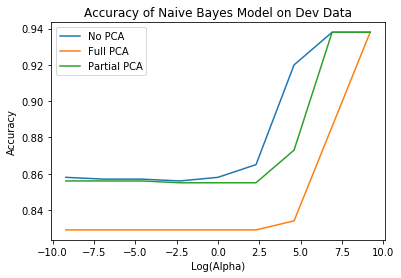

In [64]:
plt.plot(np.log(alpha), nb_acc, label='No PCA')
plt.plot(np.log(alpha), nb_acc_pca, label='Full PCA')
plt.plot(np.log(alpha), nb_acc_partial_pca, label='Partial PCA')
plt.title('Accuracy of Naive Bayes Model on Dev Data')
plt.xlabel('Log(Alpha)')
plt.ylabel('Accuracy')
plt.legend()

A Grid Search yields a best accuracy of 0.9351, which all 3 datasets are able to achieve with different values of alpha. The accuracy is roughly equivalent to our baseline of predicting all customers will not churn (0.938).

In [65]:
# Also try GridSearch

nb = BernoulliNB()
params = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]}

nb_searcher1 = GridSearchCV(nb, params)
nb_searcher1.fit(train_data_transformed, train_labels)

nb_searcher2 = GridSearchCV(nb, params)
nb_searcher2.fit(pca_train, train_labels)

nb_searcher3 = GridSearchCV(nb, params)
nb_searcher3.fit(partial_pca_train, train_labels)

print('''BEST ACCURACIES:
No PCA: {:.4f} with {}
Full PCA: {:.4f} with {}
Partial PCA: {:.4f} with {}
'''.format(nb_searcher1.best_score_, nb_searcher1.best_params_,
           nb_searcher2.best_score_, nb_searcher2.best_params_,
           nb_searcher3.best_score_, nb_searcher3.best_params_))

//anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
//anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
//anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
//anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
//anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
//anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) 

BEST ACCURACIES:
No PCA: 0.9351 with {'alpha': 0.0}
Full PCA: 0.9351 with {'alpha': 10000.0}
Partial PCA: 0.9351 with {'alpha': 1000.0}



A look at the classification report of one of the best performing models shows that the best Naive Bayes can do is to literally predict churn=0 for all members. Due to its inability to identify any churning members, this model is less useful than K-Nearest Neighbors to KKBox. 

In [66]:
# Classification report on the best performing model
# (partial PCA with alpha=1000)
nb = BernoulliNB(alpha=1000)
nb.fit(partial_pca_train, train_labels)
nb_pred = nb.predict(partial_pca_dev)

print (classification_report(dev_labels, nb_pred))


             precision    recall  f1-score   support

          0       0.94      1.00      0.97       938
          1       0.00      0.00      0.00        62

avg / total       0.88      0.94      0.91      1000



//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The area under the ROC curve is much lower than that of KNN. This is a result of Naive Bayes' difficulty in identifying churning members.

0.82766180617649088

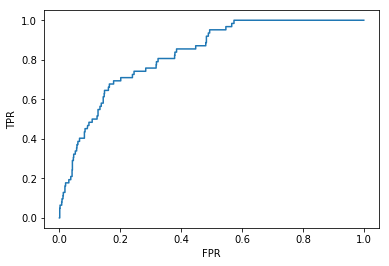

In [67]:
pred = nb.predict_proba(partial_pca_dev)[:, 1]
fpr, tpr, thresh = roc_curve(dev_labels, pred)

plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

roc_auc_score(dev_labels, pred)

## Logistic Regression
Similar to Naive Bayes and KNearest Neighbors, we train a Logistic Regression model varying between L1 and L2 Regularization and different values of the C regularization parameter, for each of the three train datasets. The Logistic Regression models have higher accuracies than Naive Bayes or K Nearest Neighbors, peaking at 0.973 on the No PCA dataset with L1 regularization, and `C=0.1`.

In [68]:
penalty = ['l1','l2']
C = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
lr_acc, lr_acc_pca, lr_acc_partial_pca = [[],[]], [[],[]], [[],[]]

for i in range(len(C)):
    for j in range(len(penalty)):
        # Fit on normal data
        lr1 = LogisticRegression(penalty=penalty[j], C=C[i])
        lr1.fit(train_data_transformed, train_labels)
        lr_acc[j].append(lr1.score(dev_data_transformed, dev_labels))

        # Fit on PCA data
        lr2 = LogisticRegression(penalty=penalty[0], C=C[i])
        lr2.fit(pca_train, train_labels)
        lr_acc_pca[j].append(lr2.score(pca_dev, dev_labels))

        # Fit on partial PCA data
        lr3 = LogisticRegression(penalty=penalty[0], C=C[i])
        lr3.fit(partial_pca_train, train_labels)
        lr_acc_partial_pca[j].append(lr3.score(partial_pca_dev, dev_labels))

In [69]:
print ('''BEST ACCURACIES:
No PCA: {:.3f} where penalty = {} & C = {}
Full PCA: {:.3f} where penalty = {} & C = {}
Partial PCA: {:.3f} where penalty = {} & C = {}
'''.format(max(max(lr_acc[0]), max(lr_acc[1])),
           'L1' if max(max(lr_acc[0]), max(lr_acc[1])) == max(lr_acc[0]) else 'L2',
           C[np.where(lr_acc[0] == max(lr_acc[0]))[0][0]] if max(max(lr_acc[0]), max(lr_acc[1])) == max(lr_acc[0]) else C[np.where(lr_acc[1] == max(lr_acc[1]))[0][0]],
           max(max(lr_acc_pca[0]), max(lr_acc_pca[1])),
           'L1' if max(max(lr_acc_pca[0]), max(lr_acc_pca[1])) == max(lr_acc_pca[0]) else 'L2',
           C[np.where(lr_acc_pca[0] == max(lr_acc_pca[0]))[0][0]] if max(max(lr_acc_pca[0]), max(lr_acc_pca[1])) == max(lr_acc_pca[0]) else C[np.where(lr_acc_pca[1] == max(lr_acc_pca[1]))[0][0]],
           max(max(lr_acc_partial_pca[0]), max(lr_acc_partial_pca[1])),
           'L1' if max(max(lr_acc_partial_pca[0]), max(lr_acc_partial_pca[1])) == max(lr_acc_partial_pca[0]) else 'L2',
           C[np.where(lr_acc_partial_pca[0] == max(lr_acc_partial_pca[0]))[0][0]] if max(max(lr_acc_partial_pca[0]), max(lr_acc_partial_pca[1])) == max(lr_acc_partial_pca[0]) else C[np.where(lr_acc_partial_pca[1] == max(lr_acc_partial_pca[1]))[0][0]]
          ))

BEST ACCURACIES:
No PCA: 0.973 where penalty = L1 & C = 0.1
Full PCA: 0.953 where penalty = L1 & C = 0.1
Partial PCA: 0.969 where penalty = L1 & C = 0.1



The accuracy of the partial PCA is comparable to the No PCA, whereas full PCA consistently performs the worst for both L1 and L2 Regularization. One explanation for this phenomenon is that by collapsing the full set of features at once into a set of components, rather than the most related features, full PCA retains less of the variance in the feature matrix.

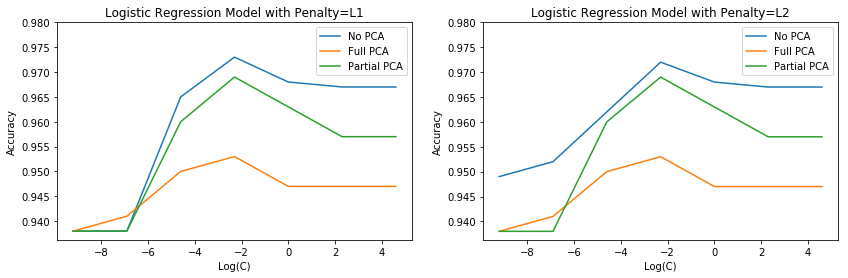

In [70]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(np.log(C), lr_acc[0], label='No PCA')
plt.plot(np.log(C), lr_acc_pca[0], label='Full PCA')
plt.plot(np.log(C), lr_acc_partial_pca[0], label='Partial PCA')
plt.title('Logistic Regression Model with Penalty=L1')
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0.94, 0.98, 0.005))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.log(C), lr_acc[1], label='No PCA')
plt.plot(np.log(C), lr_acc_pca[1], label='Full PCA')
plt.plot(np.log(C), lr_acc_partial_pca[1], label='Partial PCA')
plt.title('Logistic Regression Model with Penalty=L2')
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0.94, 0.98, 0.005))
plt.legend()

A Grid Search yields the best performing model to also be on the non PCA dataset, with accuracy of 0.9652, regularization as L1 with C=1.0. This is almost as good as the model that was tested on the dev data.

In [71]:
# Also try GridSearch
lr = LogisticRegression()
params = {'penalty': ['l1','l2'],
          'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

lr_searcher1 = GridSearchCV(lr, params)
lr_searcher1.fit(train_data_transformed, train_labels)

lr_searcher2 = GridSearchCV(lr, params)
lr_searcher2.fit(pca_train, train_labels)

lr_searcher3 = GridSearchCV(lr, params)
lr_searcher3.fit(partial_pca_train, train_labels)

print ('''BEST ACCURACIES:
No PCA: {:.4f} with {}
Full PCA: {:.4f} with {}
Partial PCA: {:.4f} with {}
'''.format(lr_searcher1.best_score_, lr_searcher1.best_params_,
           lr_searcher2.best_score_, lr_searcher2.best_params_,
           lr_searcher3.best_score_, lr_searcher3.best_params_))

BEST ACCURACIES:
No PCA: 0.9652 with {'penalty': 'l1', 'C': 1.0}
Full PCA: 0.9373 with {'penalty': 'l2', 'C': 0.001}
Partial PCA: 0.9638 with {'penalty': 'l2', 'C': 1.0}



The classification report on the best performing model shows an improvement over K-Nearest Neighbors. Like KNN, the model wrongly identifies 1% of renewing customers as churning (False Positives), but the real improvement is that it identifies 66% of churning customers as churning, compared to only 31% in KNN. This model is the most useful for KKBox.

In [72]:
# Classification report on the best performing model
# (no PCA with penalty=l1 & C=0.1)
lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(train_data_transformed, train_labels)
lr_pred = lr.predict(dev_data_transformed)

print(classification_report(dev_labels, lr_pred))

             precision    recall  f1-score   support

          0       0.98      0.99      0.99       938
          1       0.87      0.66      0.75        62

avg / total       0.97      0.97      0.97      1000



The ROC curve shows that the area under the curve is highest for the Logistic Regression classifier, at 0.989. This is in line with the highest precision rates for both classes, observed in the classification report. 

0.98949377536281724

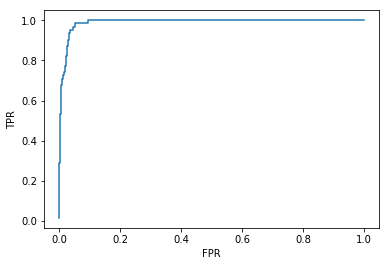

In [73]:
pred = lr.predict_proba(dev_data_transformed)[:, 1]
fpr, tpr, thresh = roc_curve(dev_labels, pred)

plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

roc_auc_score(dev_labels, pred)

### Performance on Test Set

Finally, we will see how our best model performs on the test set. Recall that our best model was a Logistic Regression with L1 regularization, C=0.1, and accuracy of 0.973.

Compared to the predictions on the dev set, we get a slightly lower accuracy of 0.963 on the test set. Of the customers that we predict will churn, the False Positive rate is higher, at 23% compared to 13% on the dev set. But, the model is still able to identify 63% of churning customers.

The ROC curve looks about the same, as expected given that we have similar precision scores (0.97 vs 0.98 for renewing members).

In [74]:
# Classification report on the best model
lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(train_data_transformed, train_labels)
lr_pred = lr.predict(test_data_transformed)

print('''Accuracy: {:.4f}'''.format(lr.score(test_data_transformed, test_labels)))
print(classification_report(test_labels, lr_pred))

Accuracy: 0.9635
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      3741
          1       0.77      0.63      0.69       259

avg / total       0.96      0.96      0.96      4000



Area Under ROC Curve: 0.9760


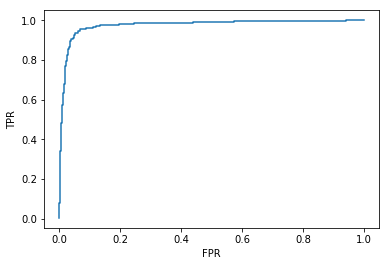

In [75]:
# ROC Curve
pred = lr.predict_proba(test_data_transformed)[:, 1]
fpr, tpr, thresh = roc_curve(test_labels, pred)

plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

print('''Area Under ROC Curve: {:.4f}'''.format(roc_auc_score(test_labels, pred)))

### Conclusion

After constructing three different supervised learning models on three different datasets, the highest accuracy we were able to achieve on the dev set was 0.973. While this may seem a marginal improvement over a model that predicts everybody will renew, we argue that KKBox is better off identifying members who may churn using the logistic regression model with no PCA, and intervening to retain those members.

Assume KKBox decides to give a \$10 bonus to every member that we predict will churn. In the test set with 4,000 members, our model predicts 213 members will churn. Of these, 164 will actually churn and 49 will not. Supposing that the \$10 bonus strategy is effective 50% of the time, KKBox will retain 82 customers for at least one additional month. The subscription payments from these customers will bring in \$149 $\times$ 82, which more than offsets the cost of giving the bonus to the 82 converts and the 49 people who would have renewed anyway.

As this model is likely to bring value, we recommend an extension from the 20,000 members to the full dataset as the logical next step.